# Model Training for Piano Arrangement

This notebook processes audio files, generates spectrograms, trains a machine learning model, and generates an arrangement from the trained model.

In [21]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
from IPython.display import Audio, display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Reshape
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
# Defining directories
BASE_DIR = './dataset/instrumental_only/'
OUTPUT_DIR = os.path.join(BASE_DIR, 'spectrograms')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'original'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'piano'), exist_ok=True)

In [66]:
# Global Constants
SR = 22050        # Number of audio samples per second
DURATION = 10     # Duration in seconds for each audio segment
TARGET_LENGTH = SR * DURATION  # Total number of samples for each audio segment (SR * DURATION)
N_MELS = 512      # Number of mel bands in spectrogram (frequency resolution)
N_FFT = 4096      # Size of the FFT window (more = better frequency resolution, worse time resolution)
HOP_LENGTH = 128  # Number of samples between successive frames (smaller = better time resolution)
WIN_LENGTH = N_FFT # Window size for analysis (matched with N_FFT for consistency)
WINDOW = 'hann'   # Type of window function (Hann window: smooth edges to reduce artifacts)
N_ITER = 256      # Number of iterations for Griffin-Lim audio reconstruction (more = better quality)

In [49]:
# Function to generate and save spectrogram
def generate_mel_spectrogram(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=SR)
        
    if len(y) > TARGET_LENGTH:
        y = y[:TARGET_LENGTH]
    else:
        y = np.pad(y, (0, max(0, TARGET_LENGTH - len(y))))
    
    S = librosa.feature.melspectrogram(
        y=y,
        sr=SR,
        n_mels=N_MELS,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        window=WINDOW,
        power=2.0
    )
    
    spectrogram_db = librosa.power_to_db(S, ref=np.max)
    np.save(save_path, spectrogram_db)
    return spectrogram_db

In [4]:
# Function to display spectrogram
def plot_spectrogram(spectrogram_db, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [5]:
# Processing audio files
def process_audios(original_dir, piano_dir):
    original_files = [f for f in os.listdir(original_dir) if f.endswith(('.mp3'))]
    piano_files = [f for f in os.listdir(piano_dir) if f.endswith(('.mp3'))]

    original_specs = []
    piano_specs = []

    for original_file, piano_file in zip(original_files, piano_files):
        original_spec = generate_mel_spectrogram(os.path.join(original_dir, original_file), os.path.join(OUTPUT_DIR, 'original', f'{original_file}.npy'))
        piano_spec = generate_mel_spectrogram(os.path.join(piano_dir, piano_file), os.path.join(OUTPUT_DIR, 'piano', f'{piano_file}.npy'))
        original_specs.append(original_spec)
        piano_specs.append(piano_spec)

    return np.array(original_specs), np.array(piano_specs)

In [72]:
# Defining the model (CNN + LSTM)
def build_model(input_shape):
    model = Sequential([
        # Entrada: (512, 1723) -> (512, 1723, 1)
        Reshape((*input_shape, 1), input_shape=input_shape),
        
        # Convolutional layers
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # -> (256, 861, 32)
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # -> (128, 430, 64)
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),  # -> (64, 215, 128)
        
        # Time dimension
        Reshape((215, 64 * 128)),  # Reorganize for temporal sequence
        
        # LSTM to capture temporal dependencies
        LSTM(512, return_sequences=True),
        
        # Output layer for each temporal step
        TimeDistributed(Dense(512)),  # Project back to 512 mel bands
        
        # Adjust the final temporal dimension
        Reshape((512, 1723))  # Final format equal to input
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [50]:
# Conversion of spectrogram to audio
def spectrogram_to_audio(spectrogram_db, sr=SR):
    spectogram = librosa.db_to_power(spectrogram_db)
    audio = librosa.feature.inverse.mel_to_audio(
        spectogram,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        window=WINDOW,
        n_iter=N_ITER,
        power=2.0
    )
    return audio

In [51]:
# Function to play audio
def play_audio(audio_path=None, y=None, spectrogram=None, sr=SR):
    if spectrogram is not None:
        y = spectrogram_to_audio(spectrogram, sr=sr)
        y = librosa.util.normalize(y)
    elif audio_path is not None:
        y, sr = librosa.load(audio_path, sr=sr)
    elif y is None:
        raise ValueError("You must provide audio_path, y or spectrogram")
    
    if len(y) > TARGET_LENGTH:
        y = y[:TARGET_LENGTH]
    else:
        y = np.pad(y, (0, max(0, TARGET_LENGTH - len(y))))
        
    display(Audio(y, rate=sr))

In [12]:
# Input directories
original_dir = os.path.join(BASE_DIR, 'original')
piano_dir = os.path.join(BASE_DIR, 'piano')

In [67]:
# Processing audio files
original_specs, piano_specs = process_audios(original_dir, piano_dir)

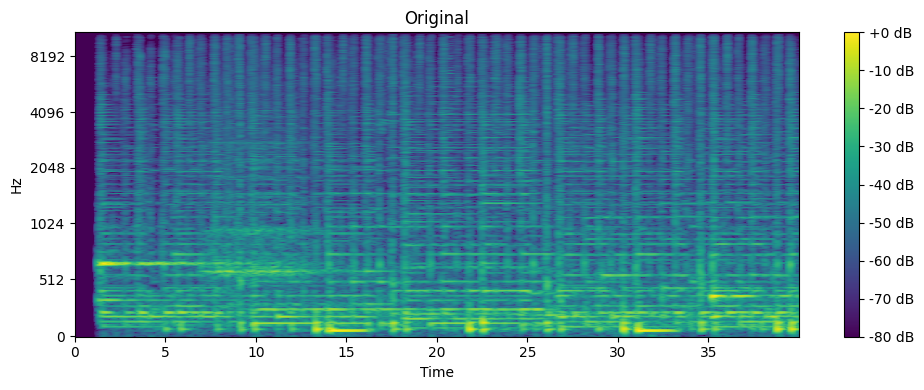

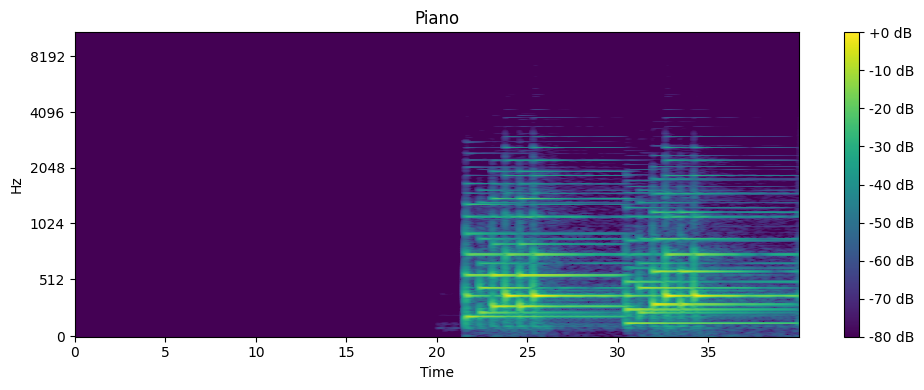

In [68]:
plot_spectrogram(original_specs[0], 'Original')
play_audio(audio_path=os.path.join(original_dir, '0000.mp3'))
play_audio(spectrogram=original_specs[0])

plot_spectrogram(piano_specs[0], 'Piano')
play_audio(audio_path=os.path.join(piano_dir, '0000.mp3'))
play_audio(spectrogram=piano_specs[0])

In [71]:
# Verify the dimensions of the data
print("Shape of original spectrograms:", original_specs.shape)
print("Shape of piano spectrograms:", piano_specs.shape)

Shape of original spectrograms: (2, 512, 1723)
Shape of piano spectrograms: (2, 512, 1723)


In [69]:
# Dividing data into train and test
X_train, X_test, y_train, y_test = train_test_split(original_specs, piano_specs, test_size=0.1, random_state=42)

# Dividing data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Checking the length of the data
len(X_train), len(X_val), len(X_test)

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Building and summarizing the model
model = build_model(X_train.shape[1:])
model.summary()

ValueError: The total size of the tensor must be unchanged. Received: input_shape=(215, 512), target_shape=(512, 1723)

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=1,
    callbacks=[early_stopping]
)

In [ ]:
# Generating an arrangement
predicted_spec = model.predict(X_test)
generated_audio = spectrogram_to_audio(predicted_spec[0])

# Saving the generated audio
librosa.output.write_wav('generated_arrangement.wav', generated_audio, sr=SR)